In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 200

import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob

from astropy.io import fits
from astropy.timeseries import BoxLeastSquares as BLS

from bls import bls
import local_linear as ll

import batman #Bad-Ass Transit Model cAlculatioN
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup, R_earth, M_earth

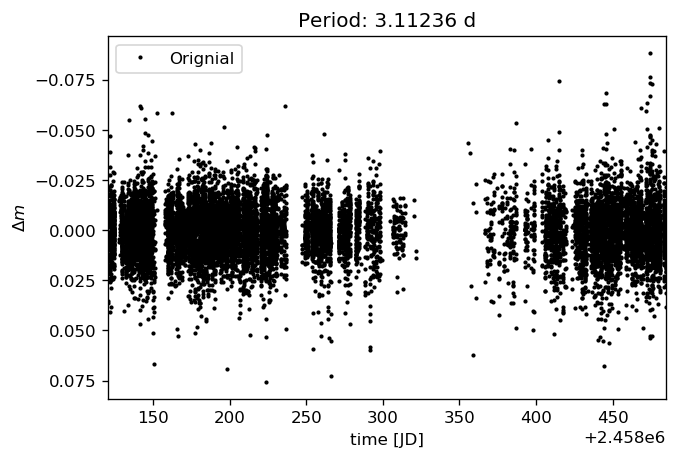

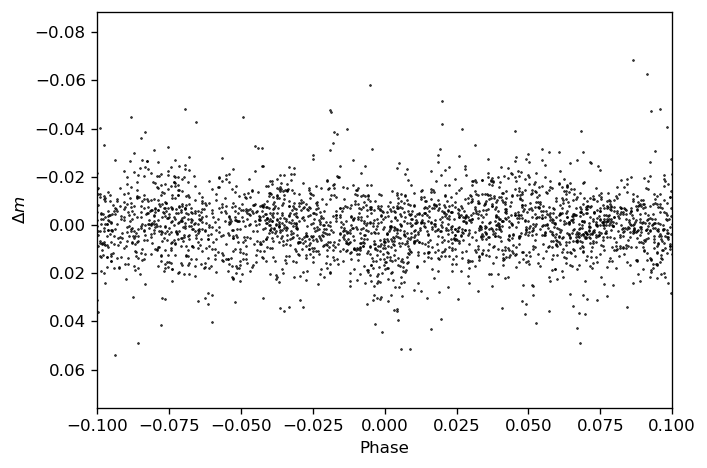

In [13]:
### Read in MASCARA data.

mascara_data_LSS = glob.glob('*LSS*')#'red0_vmag_2018Q1LSS.hdf5'
mascara_data_LSC = glob.glob('*LSC*')#sys.argv[2]
mascara_data_LSE = glob.glob('*LSE*')
mascara_data_LSW = glob.glob('*LSW*')


def get_lightcurves(mascara_data, ascc):
    
    camera = []
    for i in range(len(mascara_data)):
        camera.append(h5py.File(mascara_data[i], 'r'))
        
    lc = []
    for i in range(len(camera)):
        lc.append(camera[i]['lightcurves'][ascc][()])
        
    # Remove points binned from <=45 points.
    mask = []
    for i in range(len(lc)):
        mask.append(lc[i]['nobs'] > 45)
        lc[i] = lc[i][mask[i]]

    # Convert lst sequence to lst index.
    lstidx = []
    for i in range(len(lc)):
        lstidx.append(lc[i]['lstseq'] % 270)
        
    return lc, lstidx

lss_lc, lss_lstidx_season = get_lightcurves(mascara_data_LSS, '1934956')
#lsc_lc, lsc_lstidx_season = get_lightcurves(mascara_data_LSC, '1934956')
lse_lc, lse_lstidx_season = get_lightcurves(mascara_data_LSE, '1934956')
lsw_lc, lsw_lstidx_season = get_lightcurves(mascara_data_LSW, '1934956')


def collect_data(lc, idx):
    jd = []
    for i in range(len(lc)):
        jd.append(lc[i]['jd'])
    
    index = []
    for i in range(len(idx)):
        index.append(idx[i])
    
    return np.concatenate(jd) , np.concatenate(index)

ls_jd, ls_lstidx = np.concatenate([collect_data(lss_lc, lss_lstidx_season)[0], 
                                  collect_data(lse_lc, lse_lstidx_season)[0],
                                  collect_data(lsw_lc, lsw_lstidx_season)[0]]), \
                    np.concatenate([collect_data(lss_lc, lss_lstidx_season)[1], 
                                  collect_data(lse_lc, lse_lstidx_season)[1],
                                  collect_data(lsw_lc, lsw_lstidx_season)[1]])


### Secondary data calibriation on MASCARA by Local linear method.

def sec_cali(lc):
    
    vmag = []
    for i in range(len(lc)):
        vmag.append(lc[i]['mag0'] - ll.local_lin(lc[i]['jd'],
                                              lc[i]['lstseq'],
                                              lc[i]['x'],
                                              lc[i]['y'],
                                              lc[i]['sky'],
                                              lc[i]['mag0'],
                                              lc[i]['emag0']))
    
    return np.concatenate([vmag[0], vmag[1], vmag[2], vmag[3]])

lss_mag = sec_cali(lss_lc)+1
lse_mag = sec_cali(lse_lc)+1
lsw_mag = sec_cali(lsw_lc)+1

ls_mag = np.concatenate([lss_mag, lse_mag, lsw_mag])


def spec_digitize_mean(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmeans = [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    ymeans= [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    return xmeans,ymeans

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.nanmedian(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.nanmedian(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians


original_mag = ls_mag-1

P = 3.11236 # Days
epoch = 1520.1104+2457000

phase = np.mod(((ls_jd - epoch) / P) + .5, 1) - .5

binned_phase, binned_mag = spec_digitize_median(phase, original_mag, 300)

plt.figure()
plt.xlim(ls_jd.min(), ls_jd.max())
plt.plot(ls_jd, original_mag, '.k', ms=3, label='Orignial')
plt.gca().invert_yaxis()
plt.title("Period: {0} d".format(P))
plt.xlabel("time [JD]")
plt.ylabel(r'$\Delta m$')
plt.legend()
#plt.savefig('ascc_1359354_injected.png', dpi=200)

plt.figure()
plt.xlim(phase.min(),phase.max())
plt.ylim(original_mag.min(),original_mag.max())
plt.xlim(-0.1,0.1)
plt.plot(phase, original_mag, '.k', ms=1, label='Original')
#plt.plot(binned_phase, binned_mag, '.r', ms=5, label='Binned')
plt.gca().invert_yaxis()
#plt.title("Period: {0} d".format(P))
plt.xlabel("Phase")
plt.ylabel(r'$\Delta m$')
#plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig('ascc_1934956_phasefold.png')

In [263]:
durations = (2.44*u.h).to(u.d).value
model = BLS(ls_jd, original_mag*(-1))
results = model.autopower(durations, minimum_period=1, maximum_period=10, frequency_factor=3.0)
print(results)

          depth: array([0.00142869, 0.00143501, 0.00144398, ..., 0.06162779, 0.01302883,
       0.00261258])
      depth_err: array([0.01950852, 0.01951031, 0.01951388, ..., 1.0000366 , 0.24268666,
       0.05032341])
      depth_snr: array([0.07323391, 0.07355145, 0.07399749, ..., 0.06162554, 0.05368581,
       0.05191588])
       duration: array([0.10166667, 0.10166667, 0.10166667, ..., 0.10166667, 0.10166667,
       0.10166667])
 log_likelihood: array([0.00362303, 0.00365415, 0.00369788, ..., 0.00189899, 0.00144288,
       0.00138901])
      objective: 'likelihood'
         period: array([1.        , 1.0000023 , 1.0000046 , ..., 9.99945316, 9.99968306,
       9.99991297])
          power: array([0.00362303, 0.00365415, 0.00369788, ..., 0.00189899, 0.00144288,
       0.00138901])
   transit_time: array([0.80287496, 0.15126325, 0.49965315, ..., 3.41378054, 4.32527325,
       3.15275949])


[False False False False]


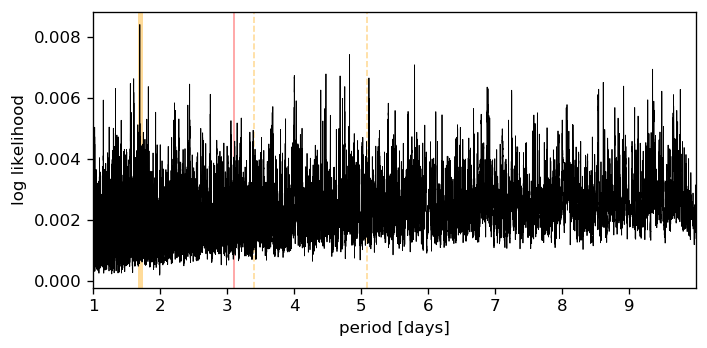

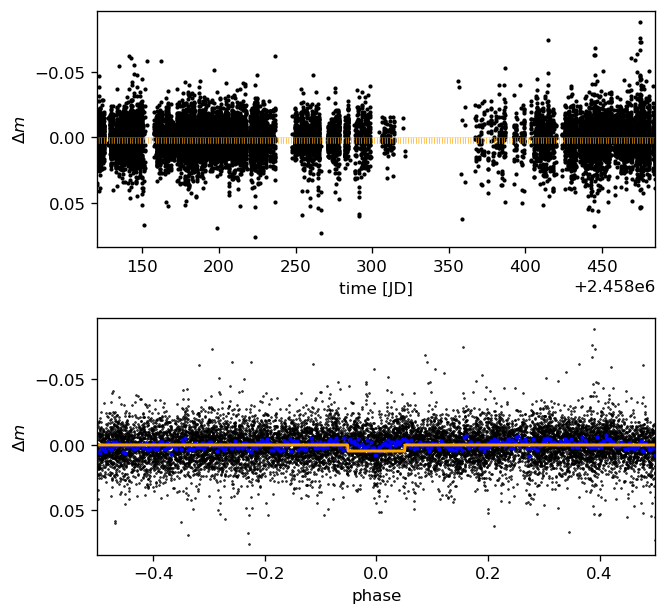

In [264]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=3, c='orange')
for n in range(2, 4):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed", c='orange')
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed", c='orange')
ax.axvline(3.11, alpha=0.4, c='r', lw=1, linestyle="solid")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)
#ax.set_xlim(0.975,1.1)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");
#ax.set_title('Periodogram')
plt.tight_layout()
plt.savefig('ascc_1934956_periodogram.png')

# Signal recovery test
def signal_recovery_test(p_inj, p_rec, N=np.array([1, 2, 1/2, 1/3])):
    return (abs(p_inj - N*p_rec)/p_inj) < 1.e-3

#signal_recovery_test(params.per, period)
print(signal_recovery_test(P, period))

# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

# Set plotting configurations
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(ls_jd, original_mag, ".k", ms=3)
x = np.linspace(ls_jd.min(), ls_jd.max(), 3*len(ls_jd))
f = model.model(x, period, duration, t0)*(-1)
ax.plot(x, f, lw=0.2, c='orange')
ax.set_xlim(ls_jd.min(), ls_jd.max())
ax.invert_yaxis()
ax.set_xlabel("time [JD]")
ax.set_ylabel(r'$\Delta m$');

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
ax.plot(phase, original_mag, ".k", ms=1)
ax.plot(binned_phase, binned_mag, '.b', ms=3, label='Binned')

# Over-plot the best fit model
x = np.linspace(phase.min(), phase.max(), 1000)
f = model.model(x + t0, period, duration, t0)*(-1)
ax.plot(x, f, lw=1.75, c='orange')
ax.set_xlim(phase.min(), phase.max())
#ax.set_xlim(-0.1,0.1)
ax.invert_yaxis()
ax.set_xlabel("phase")
ax.set_ylabel(r'$\Delta m$');

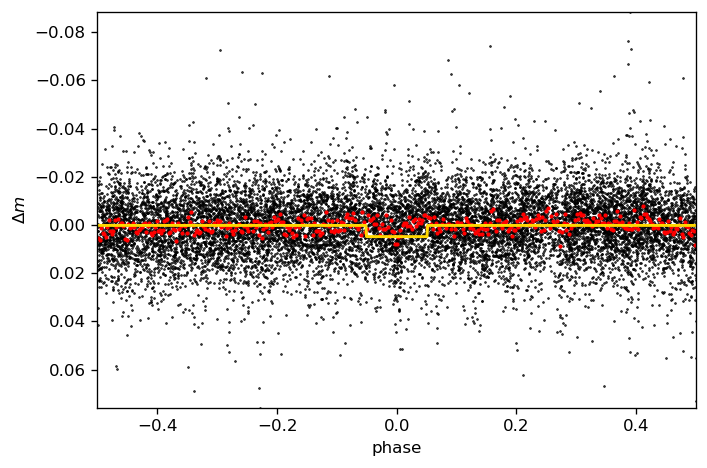

In [256]:
plt.plot(phase, original_mag, ".k", ms=1)
plt.plot(binned_phase, binned_mag, '.r', ms=3, label='Binned')

# Over-plot the best fit model
x = np.linspace(phase.min(), phase.max(), 1000)
f = model.model(x + t0, period, duration, t0)*(-1)
plt.plot(x, f, lw=1.75, c='gold')
plt.xlim(phase.min(), phase.max())
plt.ylim(original_mag.min(),original_mag.max())
plt.gca().invert_yaxis()
plt.xlabel("phase")
plt.ylabel(r'$\Delta m$');
#plt.title('Photometry')
plt.tight_layout()
plt.savefig('ascc_1934956_bls_phasefold.png')